# Tarea 3 Machine Learning  
## Métodos no lineales

Ignacio Loayza C. - 201273604-8  
Camilo Pérez P. - 201273533-5

Para la tarea entera, importaremos de inmediato todas las librerías y funciones necesarias.

In [94]:
# encoding: utf-8

# semilla
seed = hash("Ñanculef es mi pastor, nada me ha de faltar")%2^32

# librerías base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# utilidades de sklearn
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# redes neuronales
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

# árboles
from sklearn.tree import DecisionTreeClassifier as CTree
from sklearn.tree import DecisionTreeRegressor as RTree
from sklearn.ensemble import RandomForestRegressor as Forest

# KPCA
from sklearn.decomposition import KernelPCA

# SVM
from sklearn.svm import SVR

## Small circle inside large circle

La idea de esta sección consiste en generar datos sintéticos para probar el funcionamiento de varios clasificadores distintos en casos donde los datos no presenten una barrera de clasificación lineal.

### Generación de los datos

Se empleará la función `circles` para crear dos anillos concéntricos de datos a ser separados en dos clases. Para que no sea tan sencillo observar las clases, la función agregará un poco de ruido gaussiano a los datos mediante su parámetro `stddev`.

In [3]:
def circles(n = 2000, stddev = 0.05):
    generator = check_random_state(seed)
    
    linspace = np.linspace(0, 2 * np.pi, n // 2 + 1)[:-1]
    outer_circ_x = np.cos(linspace)
    outer_circ_y = np.sin(linspace)
    inner_circ_x = outer_circ_x * .3
    inner_circ_y = outer_circ_y * .3
    
    X = np.vstack((np.append(outer_circ_x, inner_circ_x), np.append(outer_circ_y, inner_circ_y))).T
    y = np.hstack([np.zeros(n // 2, dtype=np.intp), np.ones(n // 2, dtype = np.intp)])
    X += generator.normal(scale = stddev, size = X.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state = seed)
    return X_train,y_train,X_test,y_test

Se empleará también una función especial para graficar los puntos y la barrera de clasificación entregada por un clasificador dado.

In [33]:
def plot_classifier(clf, X_train, Y_train, X_test, Y_test, model_type):
    f, axis = plt.subplots(1, 1, sharex = "col", sharey = "row", figsize = (12,8))
    axis.scatter(X_train[:,0], X_train[:,1], s = 30, c = Y_train, zorder = 10, cmap = "autumn")
    axis.scatter(X_test[:,0], X_test[:,1], s = 20, c = Y_test, zorder = 10, cmap ="winter")
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
    if model_type == "tree":
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    elif model_type == "ann":
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    else:
        raise ValueError("model type not supported")
    Z = Z.reshape(XX.shape)
    Zplot = Z >= 0.5
    axis.pcolormesh(XX, YY, Zplot, cmap = "Purples")
    axis.contour(XX, YY, Z, alpha = 1, colors = ["k", "k", "k"], linestyles = ["--", "-", "--"], levels = [-2, 0, 2])
    plt.show()

Generaremos entonces una versión normal de los datos de prueba, usando la dispersión por defecto entregada ($\sigma$ = 0.05). Además, para visualizar los efectos de la incerteza en la resolución, generaremos también una copia de los datos con ruido adicional ($\sigma$ = 0.2).

In [7]:
X_train_normal, y_train_normal, X_test_normal, y_test_normal = circles()
X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy = circles(stddev = 0.2)

### Usando ANN para resolver el problema

Se intentará emplear una red con 1 neurona para observar lo que sucede.

In [73]:
def oneLayerNetwork(X_train, y_train, neurons = 1, input_init = "uniform", input_activation = "relu", hidden_init = "uniform", hidden_activation = "sigmoid", loss = "binary_crossentropy", verbosity = 0):
    model = Sequential()
    model.add(Dense(neurons, input_dim = X_train.shape[1], kernel_initializer = input_init, activation = input_activation))
    model.add(Dense(1, kernel_initializer = hidden_init, activation = hidden_activation))
    model.compile(optimizer = SGD(lr = 1), loss = loss, metrics = ["accuracy"])
    model.fit(X_train, y_train, epochs = 50, batch_size = 100, verbose = verbosity)
    return model

def evaluateNetwork(net, X_train, y_train, X_test, y_test, show_results = True):
    scores = net.evaluate(X_test, y_test)
    test_acc = scores[1]
    if show_results:
        print("\r"+ " "*60 + "\rAccuracy: %f" % test_acc)
        plot_classifier(net, X_train, y_train, X_test, y_test, "ann")
    return test_acc

In [52]:
normalModel = oneLayerNetwork(X_train_normal, y_train_normal)
noisyModel = oneLayerNetwork(X_train_noisy, y_train_noisy)

Accuracy: 0.671000                                          


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


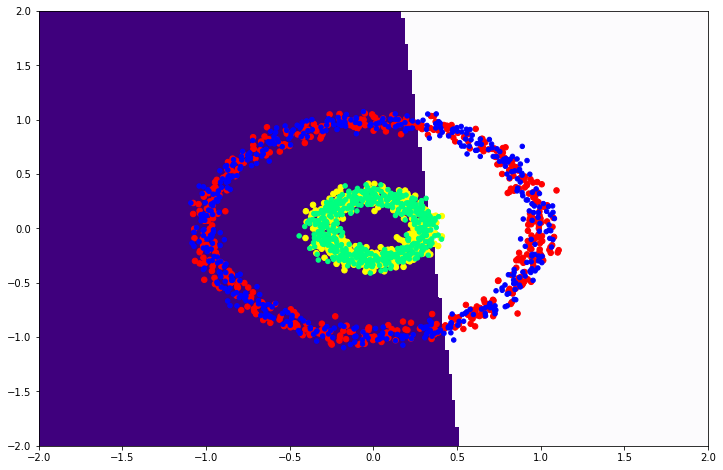

0.67100000000000004

In [59]:
evaluateNetwork(normalModel, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

La barrera de clasificación se observa en la división de colores del fondo del gráfico. La barrera es una línea recta que intenta cubrir a todos los datos del círculo interior, con problemas para clasificar los del círculo exterior.

Los colores cálidos (rojo y amarillo) corresponden a los datos de entrenamiento, y los fríos (azul y verde) a los datos de prueba.

Accuracy: 0.655000                                          


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


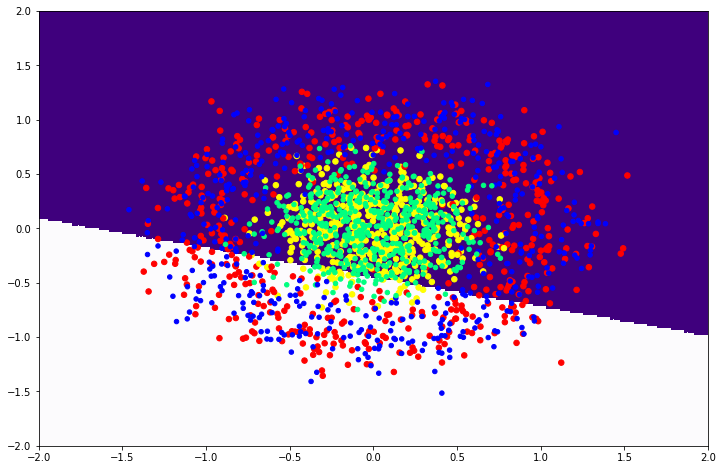

0.65500000000000003

In [60]:
evaluateNetwork(noisyModel, X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy)

Se observa que con ruido pasa lo mismo, pero se genera la barrera de una forma distinta. Por lo que sabemos de redes neuronales, no debería ser posible resolver este problema sólo con una neurona. Pero, sólo por si acaso, probemos variando unos cuantos parámetros.

Con activación sigmoidal:

Accuracy: 0.489000                                          


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


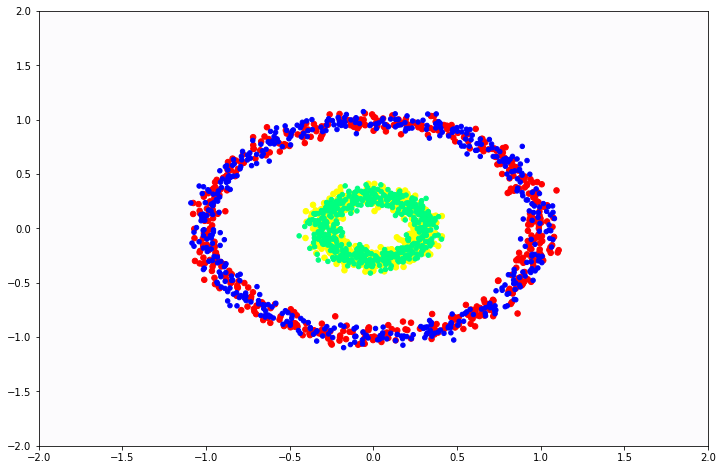

0.48899999999999999

In [64]:
testModel1 = oneLayerNetwork(X_train_normal, y_train_normal, input_activation = "sigmoid")
evaluateNetwork(testModel1, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Aparentemente la sigmoidal no es capaz de separar absolutamente nada. Es raro que el error de pruebas no sea exactamente 0.5 en todo caso...

Con activación de tangente hiperbólica:

Accuracy: 0.671000                                          


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


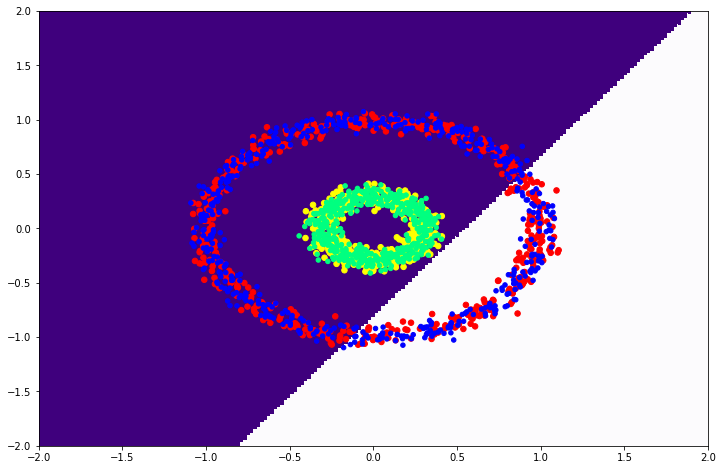

0.67100000000000004

In [65]:
testModel2 = oneLayerNetwork(X_train_normal, y_train_normal, input_activation = "tanh")
evaluateNetwork(testModel2, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Más o menos igual que antes.

Con pesos gaussianos:

Accuracy: 0.489000                                          


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


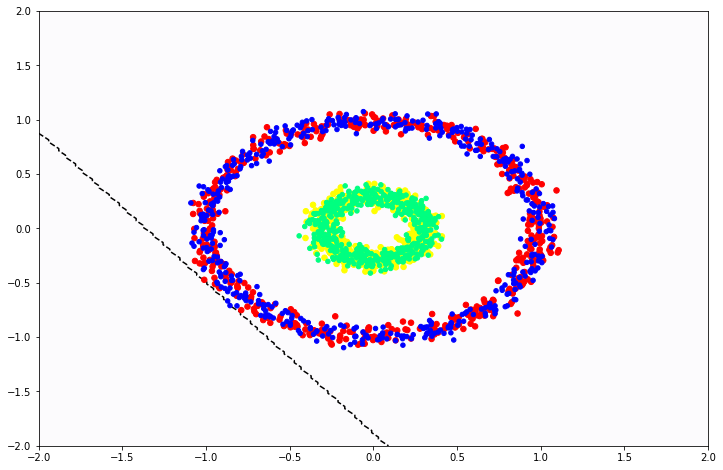

0.48899999999999999

In [66]:
testModel3 = oneLayerNetwork(X_train_normal, y_train_normal, input_init = "normal")
evaluateNetwork(testModel3, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Nótese que se define una barrera, que no se ocupa para clasificar. Nada que mirar acá.

Con error mínimo cuadrático como función de pérdida:

Accuracy: 0.700000                                          


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


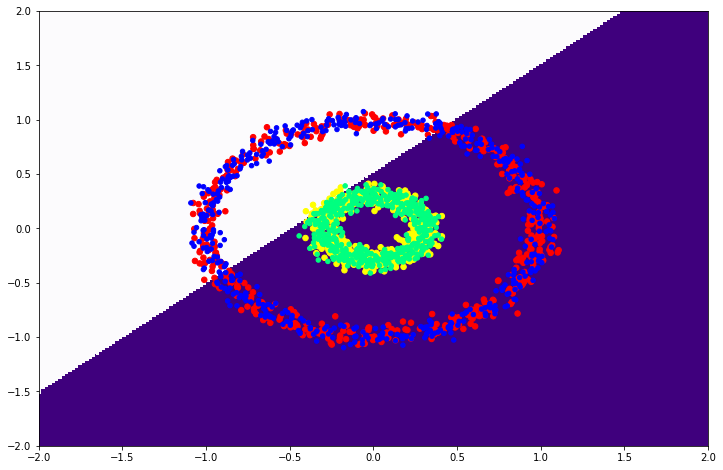

0.69999999999999996

In [67]:
testModel4 = oneLayerNetwork(X_train_normal, y_train_normal, loss = "mean_squared_error")
evaluateNetwork(testModel4, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Mejor que antes, pero no termina de convencer.

Con tangente hiperbólica, pesos gaussianos, y pérdida cuadrática media.

Accuracy: 0.332000                                          


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


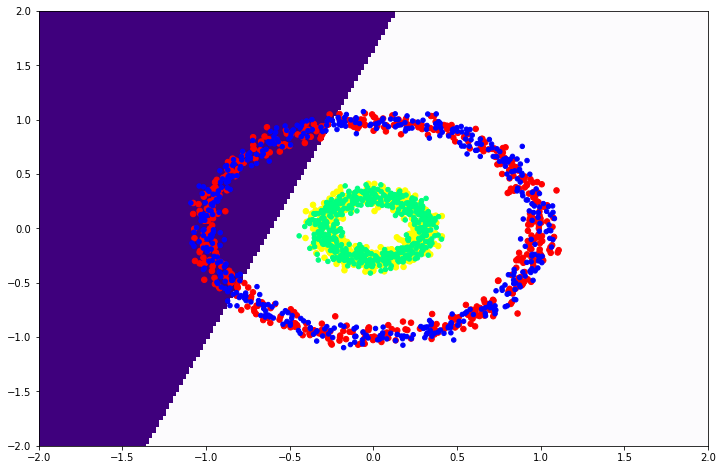

0.33200000000000002

In [68]:
testModel5 = oneLayerNetwork(X_train_normal, y_train_normal, input_init = "normal", input_activation = "tanh", loss = "mean_squared_error")
evaluateNetwork(testModel5, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Notar que aquí el clasificador prefirió invertir la clasificación. Ese 0.332 de precisión es lo mismo que un 0.668 si se mira al revés.

Ahora sí podemos llegar a la conclusión de que una sóla neurona no basta.

Empleemos ahora varias neuronas con una capa escondida, y observemos lo que sucede. Para esto emplearemos los parámetros base entregados: inicialización uniforme, activación RELU, y pérdida *cross-entropy*.

Accuracy: 0.795000                                          


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


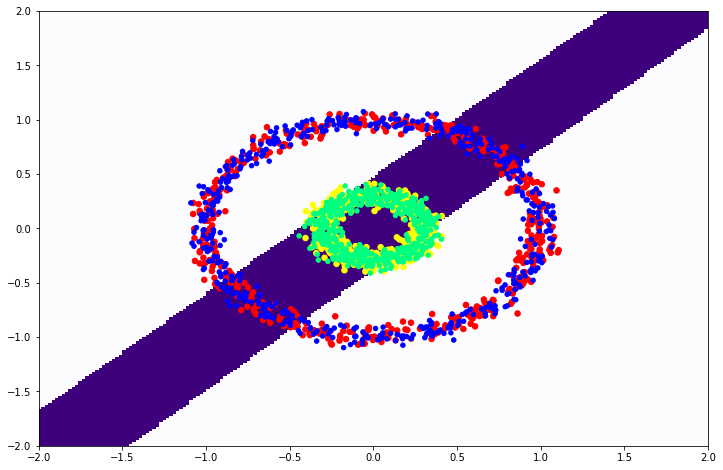

0.79500000000000004

In [69]:
twoNeuronNetwork = oneLayerNetwork(X_train_normal, y_train_normal, neurons = 2)
evaluateNetwork(twoNeuronNetwork, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Se observa una mejora considerable en la precisión de clasificación. La segunda neurona permite agregar un corte adicional al plano, acotando de mejor manera la clase interior.

Accuracy: 0.777000                                          


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


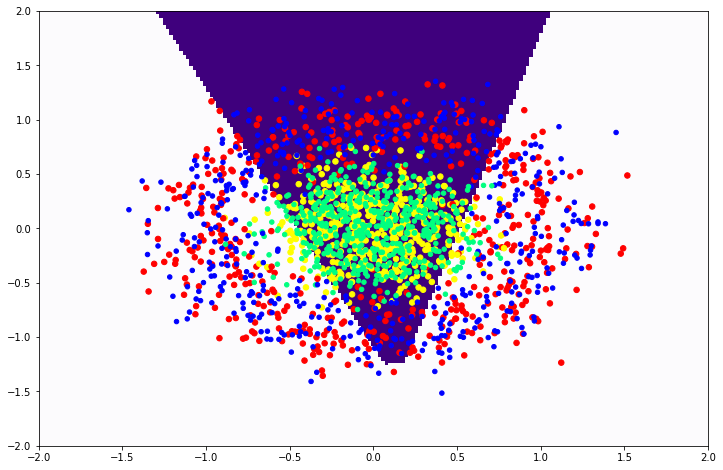

0.77700000000000002

In [70]:
twoNeuronNetwork_noisy = oneLayerNetwork(X_train_noisy, y_train_noisy, neurons = 2)
evaluateNetwork(twoNeuronNetwork_noisy, X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy)

La versión con dispersión adicional también exhibe una mejora sustancial, menor que la anterior sólo porque el ruido es una limitante fuerte.

Accuracy: 1.000000                                          


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


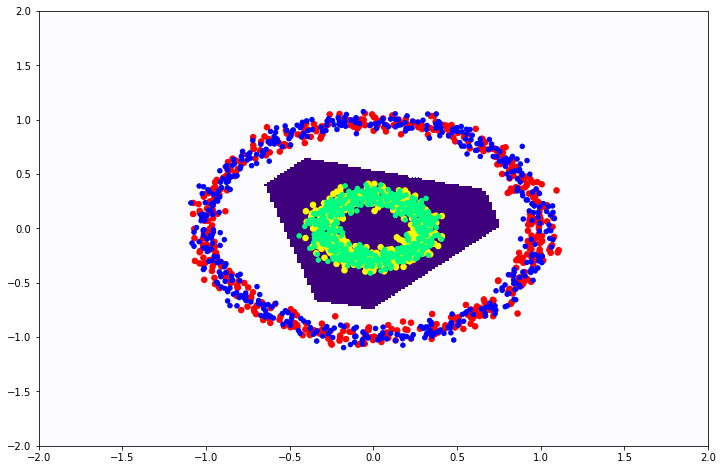

1.0

In [71]:
threeNeuronNetwork = oneLayerNetwork(X_train_normal, y_train_normal, neurons = 3)
evaluateNetwork(threeNeuronNetwork, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Con 3 neuronas ya podemos obtener una clasificación perfecta en el modelo normal.

Accuracy: 0.951000                                          


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


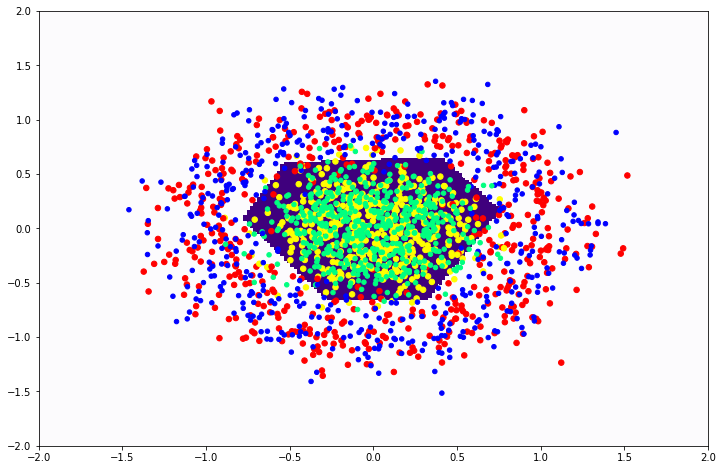

0.95099999999999996

In [72]:
threeNeuronNetwork_noisy = oneLayerNetwork(X_train_noisy, y_train_noisy, neurons = 3)
evaluateNetwork(threeNeuronNetwork_noisy, X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy)

Mientras tanto, el modelo con ruido presenta una precisión digna de un buen modelo real.

Podemos automatizar las pruebas para varias cantidades de neuronas. Como la clasificación con 3 neuronas ya llegó a precisión 1.0, aquí es donde el modelo con ruido adicional resultará ser útil.

In [77]:
neurons = [2**x for x in range(6)]
normalScore = []
noisyScore = []
for amount in neurons:
    model = oneLayerNetwork(X_train_normal, y_train_normal, neurons = amount)
    score = evaluateNetwork(model, X_train_normal, y_train_normal, X_test_normal, y_test_normal, show_results = False)
    normalScore.append(score)
    model = oneLayerNetwork(X_train_noisy, y_train_noisy, neurons = amount)
    score = evaluateNetwork(model, X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy, show_results = False)
    noisyScore.append(score)

  32/1000 [..............................] - ETA: 27s

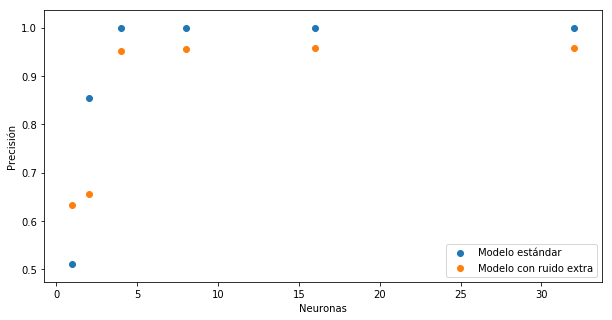

In [78]:
plt.figure(figsize = (10,5))
plt.scatter(neurons, normalScore, label = "Modelo estándar")
plt.scatter(neurons, noisyScore, label = "Modelo con ruido extra")
plt.axis("tight")
plt.xlabel("Neuronas")
plt.ylabel("Precisión")
plt.legend()
plt.show()

Aparentemente el modelo con ruido no es capaz de predecir perfectamente, sin importar la cantidad de neuronas. Esto tiene bastante sentido, pues esa era la idea del ruido en primer lugar. Estar por sobre de 0.9 en precisión ya es bueno de todas formas.

Accuracy: 0.956000                                          


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


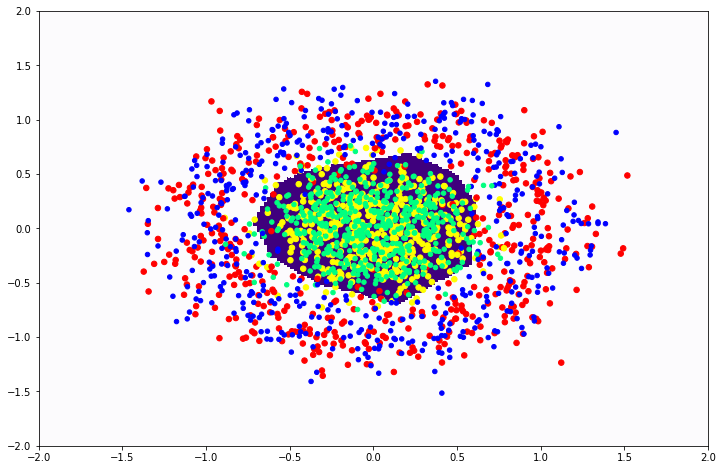

0.95599999999999996

In [79]:
displayNetwork = oneLayerNetwork(X_train_noisy, y_train_noisy, neurons = 16)
evaluateNetwork(displayNetwork, X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy)

### Usando árboles para resolver el problema

Ahora emplearemos árboles para observar la relación entre niveles del árbol y capacidad de resolver este problema. Partiremos por definir las funciones de entrenamiento y evaluación.

In [80]:
def trainTree(X_train, y_train, depth = 1, criterion = "gini", splitter = "best"):
    model = CTree(criterion = criterion, splitter = splitter, max_depth = depth, random_state = seed)
    model.fit(X_train, y_train)
    return model

def evaluateTree(tree, X_train, y_train, X_test, y_test, show_results = True):
    score = tree.score(X_test, y_test)
    if show_results:
        print("Accuracy: %f" % score)
        plot_classifier(tree, X_train, y_train, X_test, y_test, "tree")
    return score

Primero probemos lo que sucede al emplear los parámetros entregados por defecto.

Accuracy: 0.676000


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


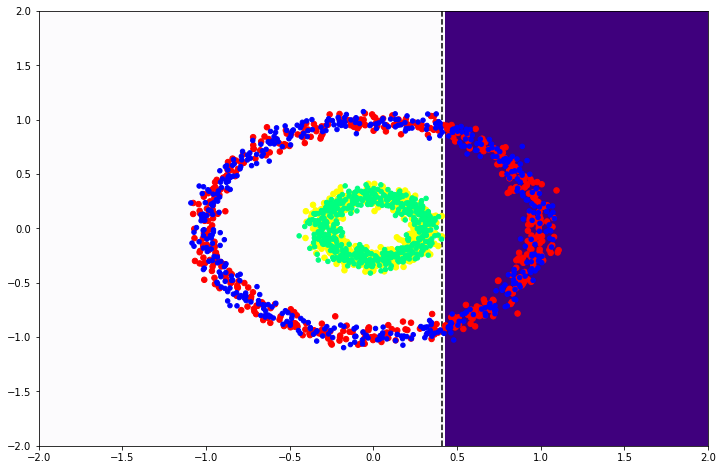

0.67600000000000005

In [81]:
testTree1 = trainTree(X_train_normal, y_train_normal)
evaluateTree(testTree1, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Se observa una barrera de clasificación lineal, correspondiente a un número cerca de 0.4. Esto se puede interpretar fácilmente como que el árbol está haciendo la pregunta "es el valor X menor a cierto parámetro?", indicando que su primera decisión se basa en la variable X.

Probemos qué pasa con los datos con ruido.

Accuracy: 0.632000


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


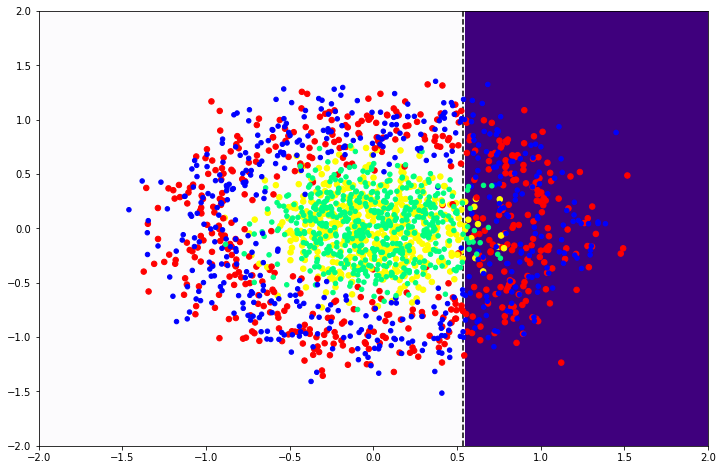

0.63200000000000001

In [82]:
testTree2 = trainTree(X_train_noisy, y_train_noisy)
evaluateTree(testTree2, X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy)

Exactamente la misma situación, variando un poco el parámetro y con una precisión ligeramente menor.

Qué sucederá con otras configuraciones para el árbol?

Accuracy: 0.676000


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


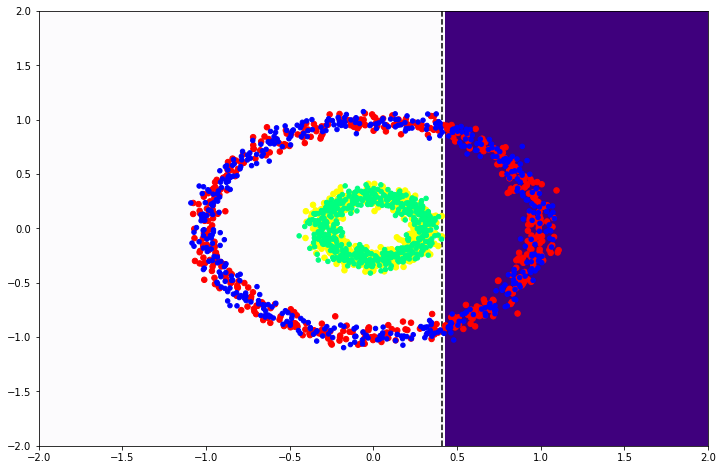

0.67600000000000005

In [83]:
testTree3 = trainTree(X_train_normal, y_train_normal, criterion = "entropy")
evaluateTree(testTree3, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Lo mismo al usar ganancia de información en vez de Gini.

Accuracy: 0.673000


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


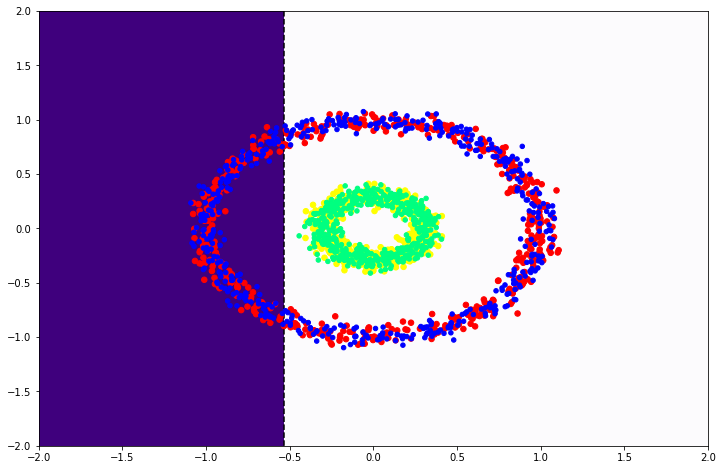

0.67300000000000004

In [85]:
testTree4 = trainTree(X_train_normal, y_train_normal, splitter = "random")
evaluateTree(testTree4, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Lo mismo al usar separación aleatoria, pero esta vez el árbol clasificó tomando el otro lado.

Accuracy: 0.673000


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


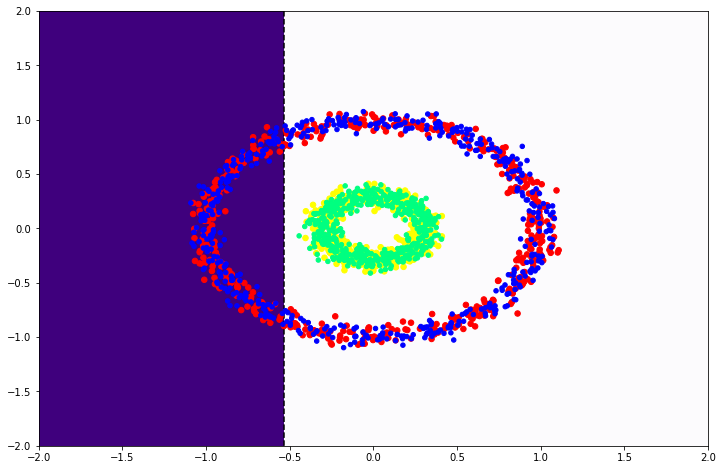

0.67300000000000004

In [86]:
testTree5 = trainTree(X_train_normal, y_train_normal, criterion = "entropy", splitter = "random")
evaluateTree(testTree5, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Y con los dos se obtiene el mismo resultado que sólamente con separación aleatoria.

Queda claro entonces que sólo con 1 nivel **no es posible realizar la separación correctamente**.

Si el árbol sigue la tendencia anterior, con dos niveles debiese mejorar sustancialmente, y con tres ya debiese clasificar perfectamente.

Accuracy: 0.863000


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


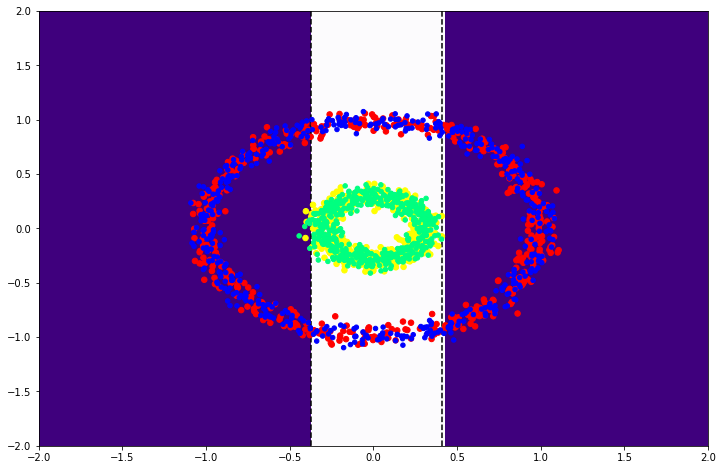

0.86299999999999999

In [87]:
testTree6 = trainTree(X_train_normal, y_train_normal, depth = 2)
evaluateTree(testTree6, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Se observan dos separaciones lineales basadas en una única variable, lo que se condice con algunos de los resultados anteriores donde se tomaba un lado de las clases o el otro. Podríamos predecir ahora que como el árbol no es capaz de manejar condiciones compuestas en términos de dos variables, entonces muy probablemente no será capaz de trazar las líneas diagonales que la red neuronal podía hacer con 3 neuronas en su primera capa. Esto implica que necesitaremos 4 niveles para hacer la clasificación en este caso.

Accuracy: 0.928000


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


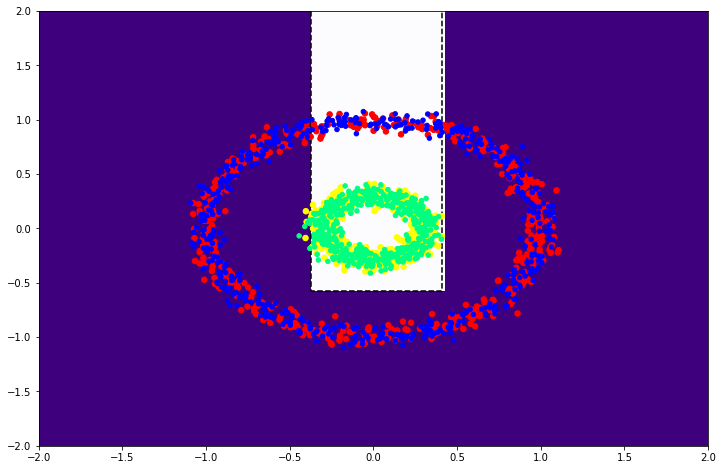

0.92800000000000005

In [88]:
testTree7 = trainTree(X_train_normal, y_train_normal, depth = 3)
evaluateTree(testTree7, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Ya con 4 es evidente que logrará encerrar el círculo central en un cuadrado perfecto. Será más interesante revisar los datos con ruido en este caso.

Accuracy: 0.932000


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


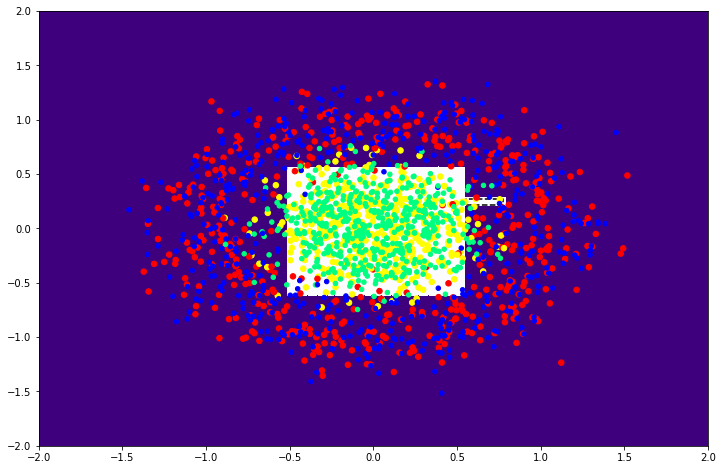

0.93200000000000005

In [90]:
testTree8 = trainTree(X_train_noisy, y_train_noisy, depth = 4)
evaluateTree(testTree8, X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy)

Para los datos con ruido, se puede observar que la primera decisión que toma es probablemente la misma que hemos visto en los gráficos anteriores: preguntarse si la variable X es mayor o menor a cierto valor cerca de 0.5. En el gráfico se puede apreciar que, de tomar cierta rama del árbol, se siguen realizando preguntas que hacen aparecer una región rectangular irregular, que probablemente intenta clasificar correctamente un par de datos adicionales. Es decir, para una altura máxima de 4 niveles, el árbol ya está mostrando tendencia al *overfitting*.

Ahora comparemos lo que pasa con el número de niveles. Se puede predecir que a partir de cierta cantidad (probablemente 4), el árbol con datos normales ya predecirá de forma perfecta, mientras que el árbol con datos con ruido puede que empiece a bajar su precisión.

In [91]:
depths = range(2, 21)
normalScore = []
noisyScore = []
for amount in depths:
    model = trainTree(X_train_normal, y_train_normal, depth = amount)
    score = evaluateTree(model, X_train_normal, y_train_normal, X_test_normal, y_test_normal, show_results = False)
    normalScore.append(score)
    model = trainTree(X_train_noisy, y_train_noisy, depth = amount)
    score = evaluateTree(model, X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy, show_results = False)
    noisyScore.append(score)

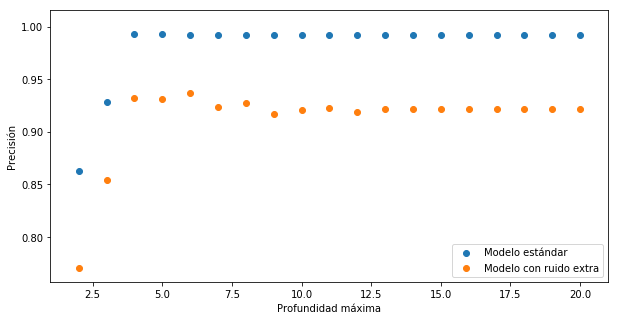

In [93]:
plt.figure(figsize = (10,5))
plt.scatter(depths, normalScore, label = "Modelo estándar")
plt.scatter(depths, noisyScore, label = "Modelo con ruido extra")
plt.axis("tight")
plt.xlabel("Profundidad máxima")
plt.ylabel("Precisión")
plt.legend()
plt.show()

Los resultados se ajustan a lo esperado. A partir de cierto punto, el modelo con ruido empieza a converger hacia cierta precisión, y se hipotetiza que probablemente se quede ahí: está clasificando perfectamente todos los datos de entrenamiento con regiones que los sobreajustan, pero está fallando en los puntos de prueba que quedan fuera de estas regiones, que serán siempre los mismos al mantenerse constantes los puntos.

La conclusión final es: **un árbol de múltiples niveles nos permite clasificar problemas linealmente inseparables**.

### Usando una transformación de espacio para linealizar el problema

Un enfoque distinto consiste en transformar los datos para convertirlos a un espacio donde adquieran una forma lineal. Es una de las técnicas que hemos visto previamente en el curso (las SVM y su *kernel trick*, por ejemplo). Ahora las aprovecharemos para aplicar cualquier técnica de naturaleza lineal. Transformaremos la variable X del problema para ver qué pasa.

In [96]:
normal_kpca = KernelPCA(n_components = 2,kernel = "rbf", gamma = 5, random_state = seed)
normal_kpca = normal_kpca.fit(X_train_normal)
Xkpca_train_normal = normal_kpca.transform(X_train_normal)
Xkpca_test_normal = normal_kpca.transform(X_test_normal)

noisy_kpca = KernelPCA(n_components = 2,kernel = "rbf", gamma = 5, random_state = seed)
noisy_kpca = noisy_kpca.fit(X_train_noisy)
Xkpca_train_noisy = noisy_kpca.transform(X_train_noisy)
Xkpca_test_noisy = noisy_kpca.transform(X_test_noisy)

Ahora necesitamos un algoritmo que pueda resolver problemas mediante fronteras lineales. Las redes neuronales de 1 sóla neurona que empleamos con anterioridad sirven, puesto que ya tenemos todo listo e implementado para usarlas.

Accuracy: 1.000000                                          


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


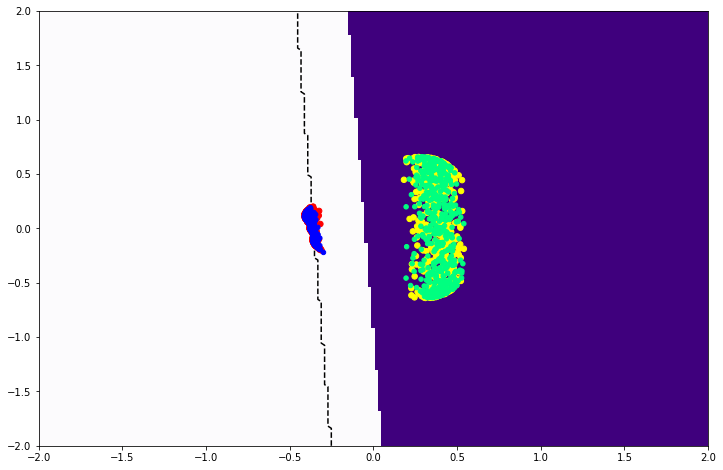

1.0

In [97]:
normal_model_kpca = oneLayerNetwork(Xkpca_train_normal, y_train_normal)
evaluateNetwork(normal_model_kpca, Xkpca_train_normal, y_train_normal, Xkpca_test_normal, y_test_normal)

La frontera simple de la red de una sóla neurona permite obtener una precisión del 100% en los datos de prueba en la región transformada.

Accuracy: 0.958000                                          


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


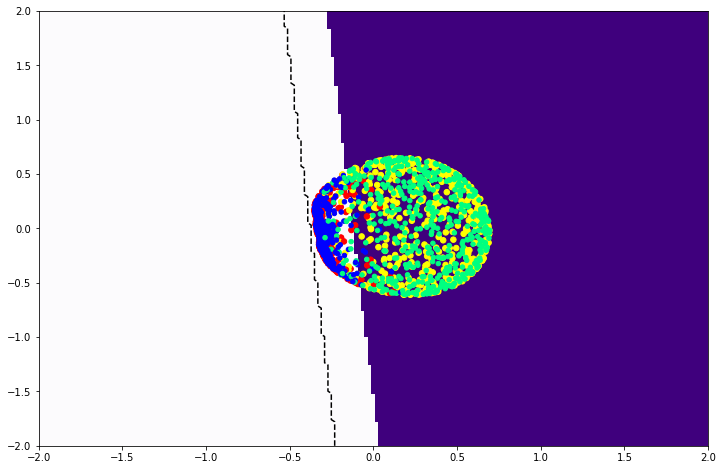

0.95799999999999996

In [98]:
noisy_model_kpca = oneLayerNetwork(Xkpca_train_noisy, y_train_noisy)
evaluateNetwork(noisy_model_kpca, Xkpca_train_noisy, y_train_noisy, Xkpca_test_noisy, y_test_noisy)

Esta clasificación ya es mejor que la de 3 neuronas para los mismos datos. Es más, es mejor que la de 16 neuronas vista anteriormente, y probablemente mejor que la de N neuronas para el mismo problema. También se comporta mejor que un árbol con muchos niveles. Destaca la forma "circular" que toman los datos después de transformar la componente X, se hipotetiza que esto se debe a la dispersión de los datos (que es de naturaleza gaussiana) y la transformación del kernel (que también es gaussiana).

Curiosamente, agregarle neuronas a la red empeora ligeramente las predicciones.

Accuracy: 0.953000                                          


C:\Users\Camilo\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


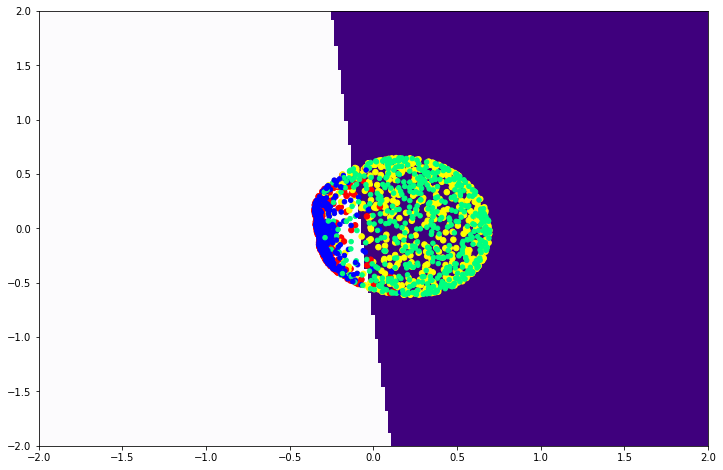

0.95299999999999996

In [104]:
noisy_model_kpca_2 = oneLayerNetwork(Xkpca_train_noisy, y_train_noisy, neurons = 32)
evaluateNetwork(noisy_model_kpca_2, Xkpca_train_noisy, y_train_noisy, Xkpca_test_noisy, y_test_noisy)

En resumen: Se puede concluir que para atacar exitosamente problemas de naturaleza no lineal, es extremadamente importante tener un buen conocimiento de las técnicas a disposición y las formas en las que pueden mejorarse y combinarse, así como las formas en las que NO deberían combinarse.